In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pos-1m-clean/1M_pos_clean_data.npy


In [2]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

In [3]:
import torch
print(torch.__version__)

2.1.2


In [4]:
data = np.load('/kaggle/input/pos-1m-clean/1M_pos_clean_data.npy')
data.shape

(995978, 279)

In [5]:
test_ind = [1,10,100]
new_data = np.delete(data,test_ind,axis=0)
new_data.shape

(995975, 279)

In [6]:
train_data = new_data
new_spec = np.zeros_like(train_data[:,:271])
for i in range(len(train_data)):
    mean_sp = np.mean(train_data[i,:269])
    std_sp = np.std(train_data[i,:269])
    new_spec[i,:269] = (train_data[i,:269] - mean_sp) / std_sp
    new_spec[i,269] = mean_sp
    new_spec[i,270] = std_sp
    #new_spec[i,271] = train_data[i,269]   # rstar
    #new_spec[i,272] = train_data[i,270]   # rplanet
    #new_spec[i,273] = train_data[i,271]   # gp
new_spec.shape

(995975, 271)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64,128,kernel_size=3,padding =1)
        self.conv4 = nn.Conv1d(128,256,kernel_size=3,padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(256 * 16, 256)  # Adjusted for pooling
        #self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(256, 7)

    def forward(self, x):
        x = x.view(x.size(0), 1, -1)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        #x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        #x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Define the R^2 loss function
class R2Loss(nn.Module):
    def __init__(self):
        super(R2Loss, self).__init__()

    def forward(self, y_pred, y_true):
        ss_res = torch.sum(torch.square(y_true - y_pred))
        ss_tot = torch.sum(torch.square(y_true - torch.mean(y_true)))
        r2 = 1 - ss_res / ss_tot
        return r2

## 10k Data

In [8]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = new_spec[:10000]
Y = new_data[:10000,272:]

scaler = StandardScaler()
Y = scaler.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

# Define training and test data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)    

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create Dataset and DataLoader for both train and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(8000, 271, 1) (8000, 7) (2000, 271, 1) (2000, 7)


In [9]:
initial_learning_rate = 1e-4
final_learning_rate = 1e-6
epochs = 50
train_size = X_train.shape[0]
batch_size = 32
lr_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)
lr_decay_factor, steps_per_epoch

(0.9120108393559098, 250)

In [10]:
# Define the neural network
net_10k = CNNModel()

input_size = (1,X_train.shape[1])
summary(net_10k, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 7]                    --
├─Conv1d: 1-1                            [1, 32, 271]              128
├─MaxPool1d: 1-2                         [1, 32, 135]              --
├─Conv1d: 1-3                            [1, 64, 135]              6,208
├─MaxPool1d: 1-4                         [1, 64, 67]               --
├─Conv1d: 1-5                            [1, 128, 67]              24,704
├─MaxPool1d: 1-6                         [1, 128, 33]              --
├─Conv1d: 1-7                            [1, 256, 33]              98,560
├─MaxPool1d: 1-8                         [1, 256, 16]              --
├─Linear: 1-9                            [1, 256]                  1,048,832
├─Dropout: 1-10                          [1, 256]                  --
├─Linear: 1-11                           [1, 7]                    1,799
Total params: 1,180,231
Trainable params: 1,180,231
Non-trainab

Epoch [1/50] Train Loss: 0.603, Train R2: 0.394, Test Loss: 0.413, Test R2: 0.588
Epoch [2/50] Train Loss: 0.380, Train R2: 0.618, Test Loss: 0.336, Test R2: 0.664
Epoch [3/50] Train Loss: 0.325, Train R2: 0.673, Test Loss: 0.304, Test R2: 0.697
Epoch [4/50] Train Loss: 0.295, Train R2: 0.703, Test Loss: 0.280, Test R2: 0.720
Epoch [5/50] Train Loss: 0.275, Train R2: 0.723, Test Loss: 0.270, Test R2: 0.730
Epoch [6/50] Train Loss: 0.260, Train R2: 0.738, Test Loss: 0.255, Test R2: 0.745
Epoch [7/50] Train Loss: 0.249, Train R2: 0.750, Test Loss: 0.240, Test R2: 0.761
Epoch [8/50] Train Loss: 0.240, Train R2: 0.758, Test Loss: 0.232, Test R2: 0.769
Epoch [9/50] Train Loss: 0.232, Train R2: 0.767, Test Loss: 0.227, Test R2: 0.774
Epoch [10/50] Train Loss: 0.225, Train R2: 0.773, Test Loss: 0.219, Test R2: 0.781
Epoch [11/50] Train Loss: 0.220, Train R2: 0.778, Test Loss: 0.219, Test R2: 0.781
Epoch [12/50] Train Loss: 0.215, Train R2: 0.783, Test Loss: 0.210, Test R2: 0.790
Epoch [13/50]

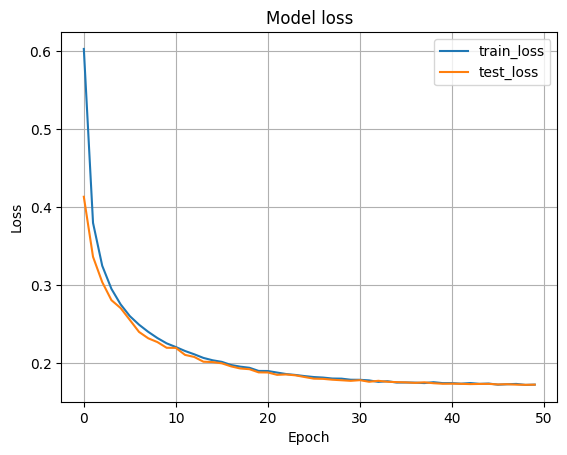

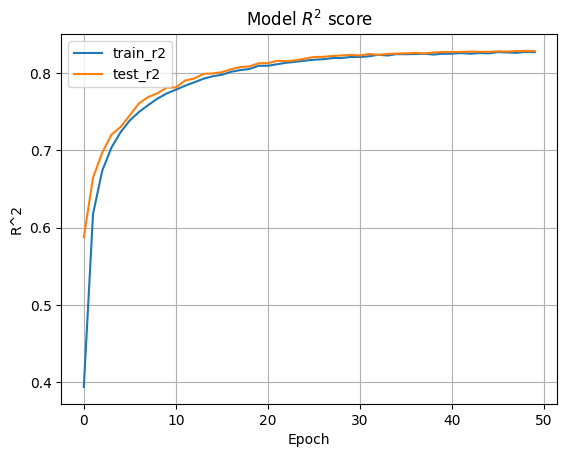

In [11]:
model = net_10k

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer,gamma=lr_decay_factor)

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
epochs = 50

losses = []
r2s = []
test_losses = []
test_r2s = []
cur_lrs =[]
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_r2 = 0.0
    for i, (inputs, targets) in enumerate(train_loader, 0):
        # Move inputs and targets to the device
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss (use the output from the last time step)
        loss = criterion(outputs, targets)
        r2 = R2Loss()(outputs, targets)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        running_r2 += r2.item()
        
    losses.append(running_loss / len(train_loader))
    r2s.append(running_r2 / len(train_loader))
    
    # Testing the model
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_r2 = 0.0
    with torch.no_grad():  # No need to compute gradients during testing
        for inputs, targets in test_loader:
            # Move inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the test loss
            loss = criterion(outputs, targets)
            r2 = R2Loss()(outputs, targets)
            
            # Accumulate the test loss
            test_loss += loss.item()
            test_r2 += r2.item()
            
    # Average test loss
    avg_test_loss = test_loss / len(test_loader)
    avg_test_r2 = test_r2 / len(test_loader)
    test_losses.append(avg_test_loss)
    test_r2s.append(avg_test_r2)
    print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {running_loss / len(train_loader):.3f}, Train R2: {running_r2/len(train_loader):.3f}, Test Loss: {avg_test_loss:.3f}, Test R2: {avg_test_r2:.3f}')
    
    current_lr = optimizer.param_groups[0]['lr']
    cur_lrs.append(current_lr)   
    scheduler.step()
    
    
print()
print('!!!Training complete!!!')
print()

# plotting model loss    
plt.plot(losses,label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend()
plt.grid()
plt.show()
# plotting model r2 score
plt.plot(r2s, label='train_r2')
plt.plot(test_r2s, label='test_r2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.title('Model $R^{2}$ score')
plt.legend()
plt.grid()
plt.show()

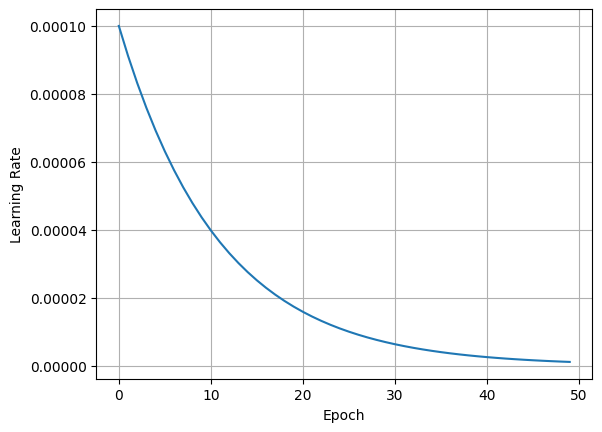

In [12]:
plt.plot( cur_lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid()
plt.show()

In [13]:
path = 'cnn_10k_m_s'
torch.save(model,path)

In [14]:
y_pred = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Predict outputs
        outputs = model(inputs)
        
        y_pred.append(outputs.cpu().numpy()) 

pred = np.concatenate(y_pred, axis=0)

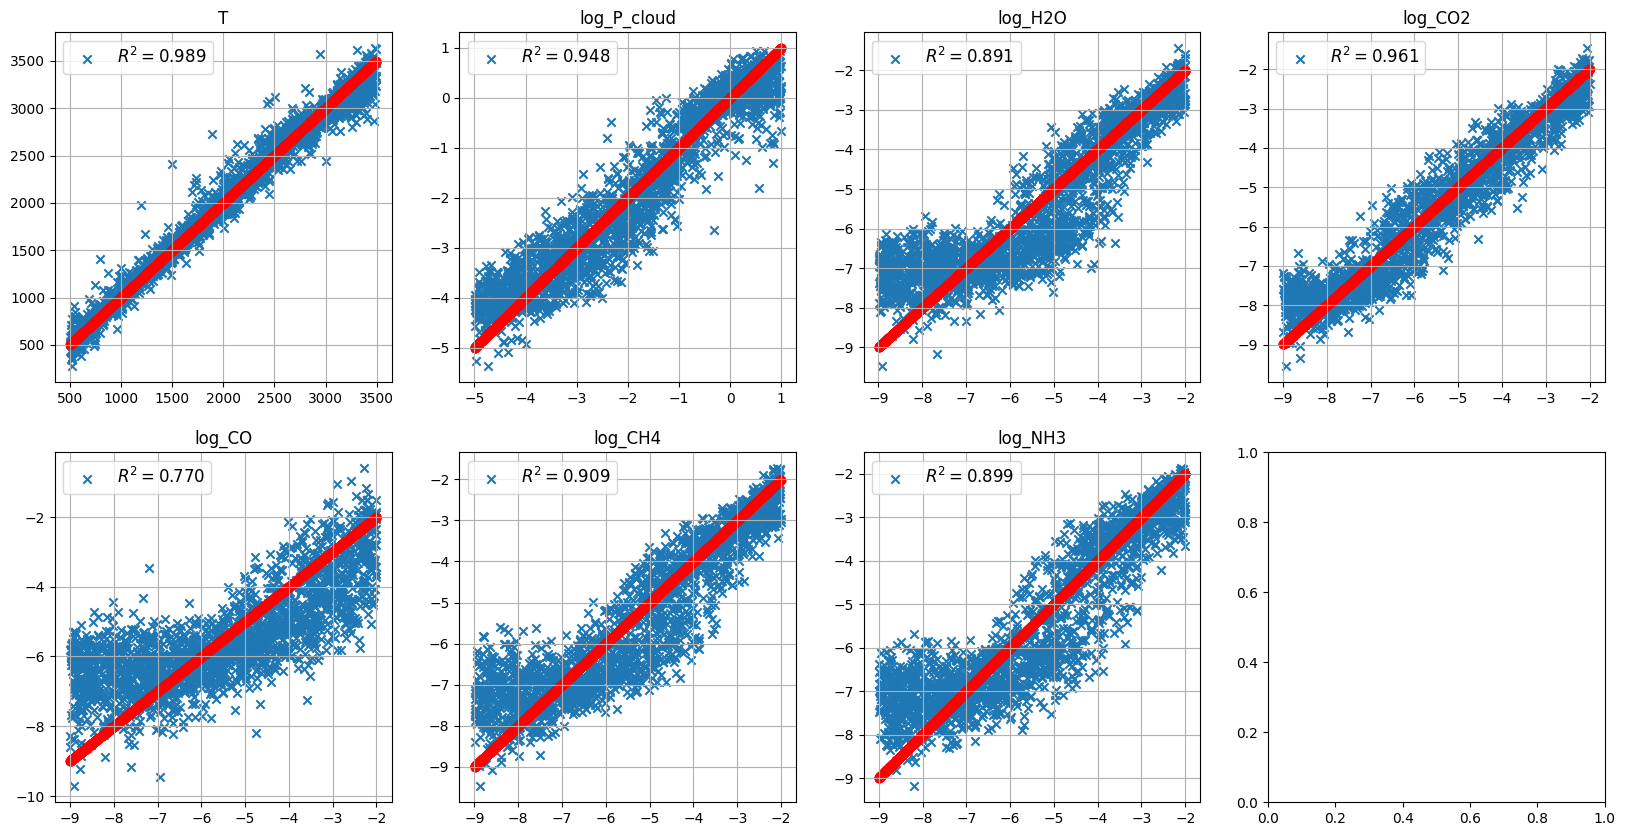

In [15]:
from scipy.stats import pearsonr

keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = pred
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[0,i].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[1,i-4].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

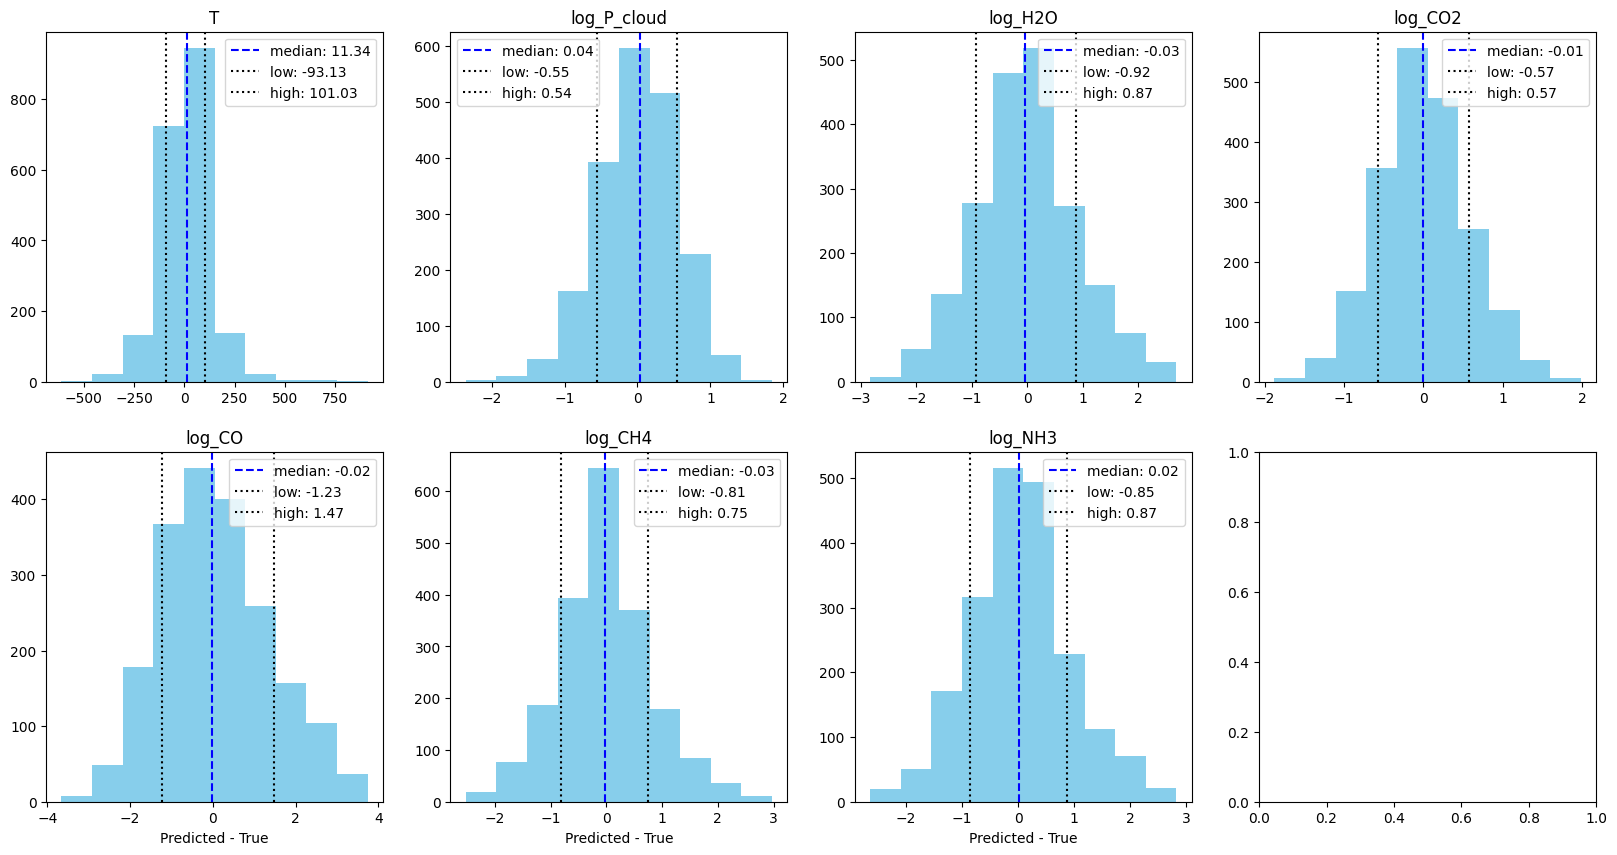

In [16]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = pred
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[0,i].hist(pred_err,bins=10,color='skyblue')
        axs[0,i].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[0,i].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[0,i].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[1,i-4].hist(pred_err,bins=10,color='skyblue')
        axs[1,i-4].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[1,i-4].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[1,i-4].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')

In [17]:
y_test_rescaled_10k = scaler.inverse_transform(y_test)
predictions_10k = pred
predictions_10k = scaler.inverse_transform(predictions_10k)

## Testing on the retreived planets

In [18]:
file_data =np.load('/kaggle/input/pos-1m-clean/1M_pos_clean_data.npy')

In [19]:
mean = np.mean(file_data[1,:269])
std = np.std(file_data[1,:269])
planetA_spec = (file_data[1,:269] - mean) / std
FH = np.max(file_data[1,:269]) - np.min(file_data[1,:269])
planetA_spec = np.concatenate([planetA_spec,np.array([mean]),np.array([std])])
#planetA_spec = np.concatenate([planetA_spec,np.array([mean]),np.array([std]),np.array([file_data[1,269]]), np.array([file_data[1,270]]), np.array([file_data[1,271]])])
planetA_params = file_data[1,269:]
planetA_spec.shape, planetA_params.shape

((271,), (10,))

In [20]:
mean = np.mean(file_data[10,:269])
std = np.std(file_data[10,:269])
planetB_spec = (file_data[10,:269] - mean) / std
FH = np.max(file_data[10,:269]) - np.min(file_data[10,:269])
planetB_spec = np.concatenate([planetB_spec,np.array([mean]),np.array([std])])
#planetB_spec = np.concatenate([planetB_spec,np.array([mean]),np.array([std]),np.array([file_data[10,269]]), np.array([file_data[10,270]]), np.array([file_data[10,271]])])
planetB_params = file_data[10,269:]
planetB_spec.shape, planetB_params.shape

((271,), (10,))

In [21]:
mean = np.mean(file_data[100,:269])
std = np.std(file_data[100,:269])
planetC_spec = (file_data[100,:269] - mean) / std
FH = np.max(file_data[100,:269]) - np.min(file_data[100,:269])
planetC_spec = np.concatenate([planetC_spec,np.array([mean]),np.array([std])])
#planetC_spec = np.concatenate([planetC_spec,np.array([mean]),np.array([std]),np.array([file_data[100,269]]), np.array([file_data[100,270]]), np.array([file_data[100,271]])])
planetC_params = file_data[100,269:]
planetC_spec.shape, planetC_params.shape

((271,), (10,))

In [22]:
test_planets = np.array([planetA_spec,planetB_spec,planetC_spec])
test_planets = test_planets.reshape(3,271,1)
test_planets.shape

(3, 271, 1)

In [23]:
pred_data = torch.from_numpy(test_planets).float()
with torch.no_grad():
    pred_data = pred_data.to(device)
    pred = net_10k(pred_data)    
pred = np.array(pred.cpu())    
pred.shape

(3, 7)

In [24]:
pred = scaler.inverse_transform(pred)
pred

array([[ 2.3771416e+03, -3.0335921e-01, -7.3096237e+00, -8.2291164e+00,
        -5.2455144e+00, -3.4735210e+00, -3.2778730e+00],
       [ 9.8889386e+02,  3.1667966e-01, -2.7377288e+00, -2.6015663e+00,
        -6.1163125e+00, -6.3583808e+00, -5.6909552e+00],
       [ 2.5765217e+03, -3.6179862e+00, -6.6152267e+00, -4.9607973e+00,
        -7.2553487e+00, -2.9648385e+00, -6.4420724e+00]], dtype=float32)

In [25]:
planetA_pred_10k = pred[0]
print("Predicted values:",planetA_pred_10k)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.3771416e+03 -3.0335921e-01 -7.3096237e+00 -8.2291164e+00
 -5.2455144e+00 -3.4735210e+00 -3.2778730e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


In [26]:
planetB_pred_10k = pred[1]
print("Predicted values:",planetB_pred_10k)
print("Actual values:",planetB_params[3:])

Predicted values: [ 9.8889386e+02  3.1667966e-01 -2.7377288e+00 -2.6015663e+00
 -6.1163125e+00 -6.3583808e+00 -5.6909552e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


In [27]:
planetC_pred_10k = pred[2]
print("Predicted values:",planetC_pred_10k)
print("Actual values:",planetC_params[3:])

Predicted values: [2576.5217      -3.6179862   -6.6152267   -4.9607973   -7.2553487
   -2.9648385   -6.4420724]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


## 100k data

In [28]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = new_spec[:100000]
Y = new_data[:100000,272:]

scaler = StandardScaler()
Y = scaler.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

# Define training and test data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)    

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create Dataset and DataLoader for both train and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(80000, 271, 1) (80000, 7) (20000, 271, 1) (20000, 7)


In [29]:
initial_learning_rate = 1e-4
final_learning_rate = 1e-6
epochs = 50
train_size = X_train.shape[0]
batch_size = 32
lr_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)
lr_decay_factor, steps_per_epoch

(0.9120108393559098, 2500)

In [30]:
# Define the neural network
net_100k = CNNModel()

input_size = (1,X_train.shape[1])
summary(net_100k, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 7]                    --
├─Conv1d: 1-1                            [1, 32, 271]              128
├─MaxPool1d: 1-2                         [1, 32, 135]              --
├─Conv1d: 1-3                            [1, 64, 135]              6,208
├─MaxPool1d: 1-4                         [1, 64, 67]               --
├─Conv1d: 1-5                            [1, 128, 67]              24,704
├─MaxPool1d: 1-6                         [1, 128, 33]              --
├─Conv1d: 1-7                            [1, 256, 33]              98,560
├─MaxPool1d: 1-8                         [1, 256, 16]              --
├─Linear: 1-9                            [1, 256]                  1,048,832
├─Dropout: 1-10                          [1, 256]                  --
├─Linear: 1-11                           [1, 7]                    1,799
Total params: 1,180,231
Trainable params: 1,180,231
Non-trainab

Epoch [1/50] Train Loss: 0.290, Train R2: 0.709, Test Loss: 0.188, Test R2: 0.811
Epoch [2/50] Train Loss: 0.173, Train R2: 0.826, Test Loss: 0.145, Test R2: 0.854
Epoch [3/50] Train Loss: 0.144, Train R2: 0.855, Test Loss: 0.123, Test R2: 0.876
Epoch [4/50] Train Loss: 0.128, Train R2: 0.871, Test Loss: 0.111, Test R2: 0.888
Epoch [5/50] Train Loss: 0.118, Train R2: 0.882, Test Loss: 0.097, Test R2: 0.903
Epoch [6/50] Train Loss: 0.110, Train R2: 0.889, Test Loss: 0.096, Test R2: 0.903
Epoch [7/50] Train Loss: 0.104, Train R2: 0.895, Test Loss: 0.091, Test R2: 0.909
Epoch [8/50] Train Loss: 0.099, Train R2: 0.900, Test Loss: 0.087, Test R2: 0.913
Epoch [9/50] Train Loss: 0.096, Train R2: 0.904, Test Loss: 0.084, Test R2: 0.916
Epoch [10/50] Train Loss: 0.093, Train R2: 0.907, Test Loss: 0.086, Test R2: 0.914
Epoch [11/50] Train Loss: 0.090, Train R2: 0.910, Test Loss: 0.075, Test R2: 0.925
Epoch [12/50] Train Loss: 0.087, Train R2: 0.912, Test Loss: 0.074, Test R2: 0.926
Epoch [13/50]

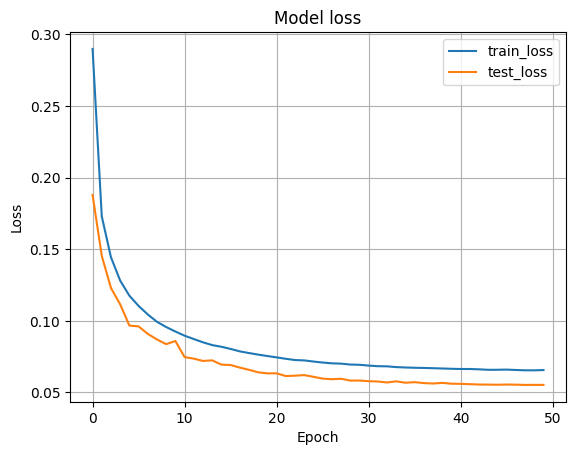

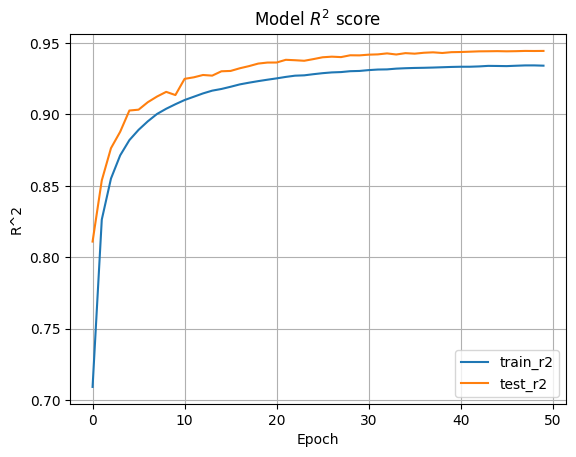

In [31]:
model = net_100k

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer,gamma=lr_decay_factor)

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
epochs = 50

losses = []
r2s = []
test_losses = []
test_r2s = []
cur_lrs =[]
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_r2 = 0.0
    for i, (inputs, targets) in enumerate(train_loader, 0):
        # Move inputs and targets to the device
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss (use the output from the last time step)
        loss = criterion(outputs, targets)
        r2 = R2Loss()(outputs, targets)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        running_r2 += r2.item()
        
    losses.append(running_loss / len(train_loader))
    r2s.append(running_r2 / len(train_loader))
    
    # Testing the model
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_r2 = 0.0
    with torch.no_grad():  # No need to compute gradients during testing
        for inputs, targets in test_loader:
            # Move inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the test loss
            loss = criterion(outputs, targets)
            r2 = R2Loss()(outputs, targets)
            
            # Accumulate the test loss
            test_loss += loss.item()
            test_r2 += r2.item()
            
    # Average test loss
    avg_test_loss = test_loss / len(test_loader)
    avg_test_r2 = test_r2 / len(test_loader)
    test_losses.append(avg_test_loss)
    test_r2s.append(avg_test_r2)
    print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {running_loss / len(train_loader):.3f}, Train R2: {running_r2/len(train_loader):.3f}, Test Loss: {avg_test_loss:.3f}, Test R2: {avg_test_r2:.3f}')
    
    current_lr = optimizer.param_groups[0]['lr']
    cur_lrs.append(current_lr)   
    scheduler.step()
    
    
print()
print('!!!Training complete!!!')
print()

# plotting model loss    
plt.plot(losses,label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend()
plt.grid()
plt.show()
# plotting model r2 score
plt.plot(r2s, label='train_r2')
plt.plot(test_r2s, label='test_r2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.title('Model $R^{2}$ score')
plt.legend()
plt.grid()
plt.show()

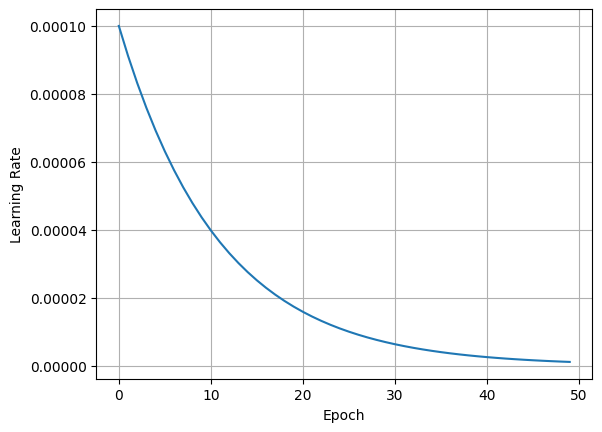

In [32]:
plt.plot( cur_lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid()
plt.show()

In [33]:
net_100k = model
path = 'cnn_100k_m_s'
torch.save(net_100k,path)

In [34]:
y_pred = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Predict outputs
        outputs = model(inputs)
        
        y_pred.append(outputs.cpu().numpy()) 

pred = np.concatenate(y_pred, axis=0)

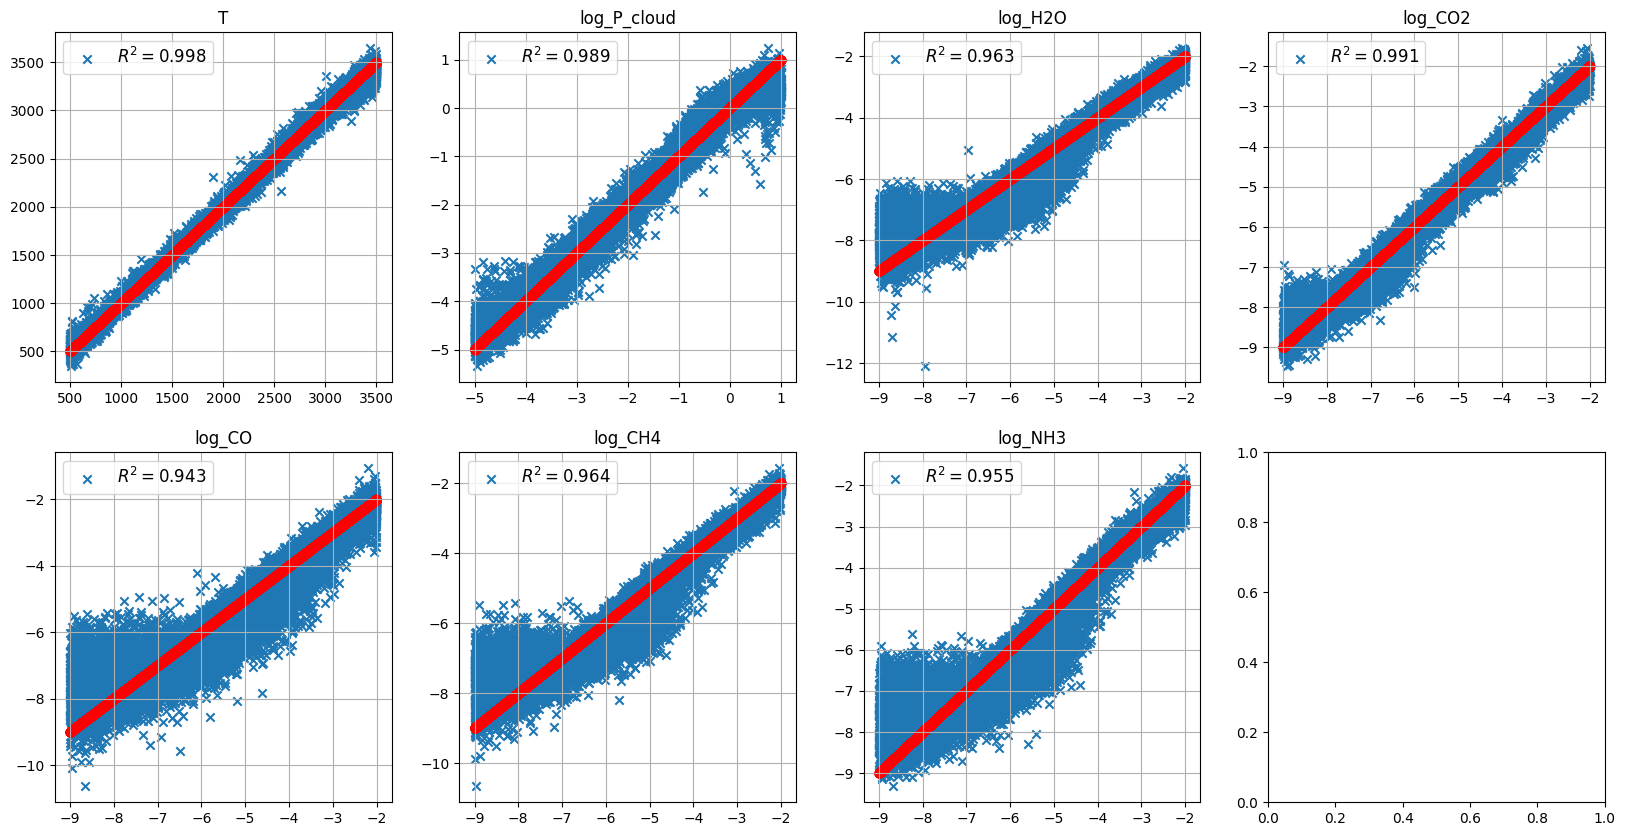

In [35]:
from scipy.stats import pearsonr

keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = pred
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[0,i].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[1,i-4].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

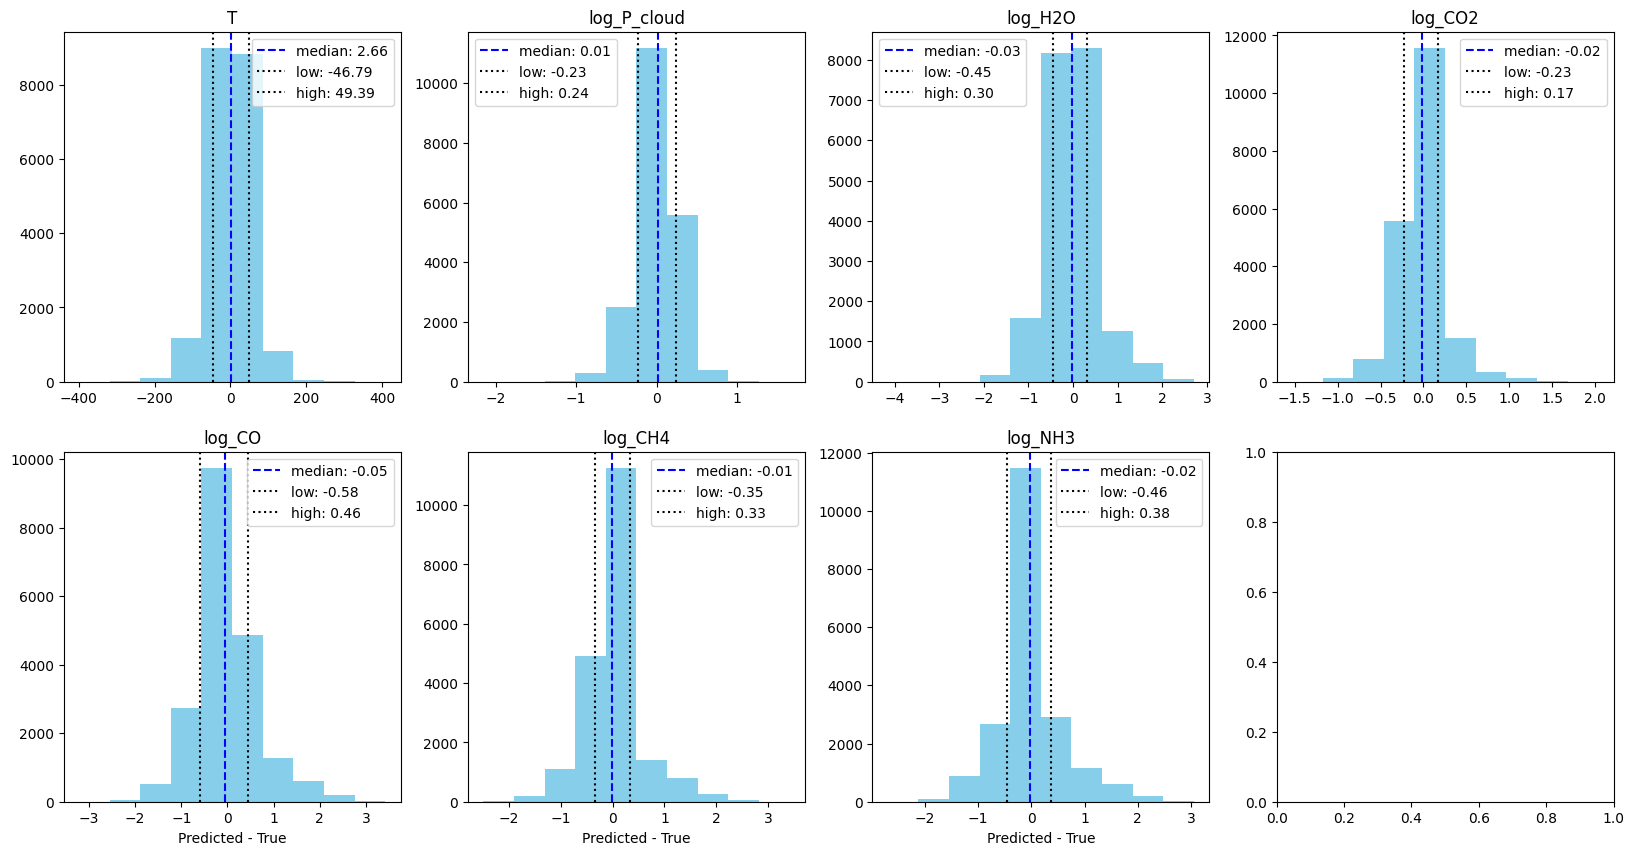

In [36]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = pred
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[0,i].hist(pred_err,bins=10,color='skyblue')
        axs[0,i].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[0,i].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[0,i].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[1,i-4].hist(pred_err,bins=10,color='skyblue')
        axs[1,i-4].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[1,i-4].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[1,i-4].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')

In [37]:
y_test_rescaled_100k = scaler.inverse_transform(y_test)
predictions_100k = pred
predictions_100k = scaler.inverse_transform(predictions_100k)

In [38]:
pred_data = torch.from_numpy(test_planets).float()
with torch.no_grad():
    pred_data = pred_data.to(device)
    pred = net_100k(pred_data)    
pred = np.array(pred.cpu())    
pred = scaler.inverse_transform(pred)
pred

array([[ 2.1234319e+03,  1.5426733e-01, -7.3163662e+00, -8.0469055e+00,
        -4.9340754e+00, -3.7601972e+00, -4.1466718e+00],
       [ 1.1113879e+03,  2.2385789e-01, -2.7968278e+00, -2.6441274e+00,
        -8.3566103e+00, -5.6745615e+00, -5.0971003e+00],
       [ 2.6813884e+03, -3.5424316e+00, -6.5310884e+00, -5.4203334e+00,
        -6.9559665e+00, -2.8793664e+00, -6.5612602e+00]], dtype=float32)

In [39]:
planetA_pred_100k = pred[0]
print("Predicted values:",planetA_pred_100k)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.1234319e+03  1.5426733e-01 -7.3163662e+00 -8.0469055e+00
 -4.9340754e+00 -3.7601972e+00 -4.1466718e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


In [40]:
planetB_pred_100k = pred[1]
print("Predicted values:",planetB_pred_100k)
print("Actual values:",planetB_params[3:])

Predicted values: [ 1.1113879e+03  2.2385789e-01 -2.7968278e+00 -2.6441274e+00
 -8.3566103e+00 -5.6745615e+00 -5.0971003e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


In [41]:
planetC_pred_100k = pred[2]
print("Predicted values:",planetC_pred_100k)
print("Actual values:",planetC_params[3:])

Predicted values: [2681.3884      -3.5424316   -6.5310884   -5.4203334   -6.9559665
   -2.8793664   -6.56126  ]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


## 1M data

In [42]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = new_spec
Y = new_data[:,272:]

scaler = StandardScaler()
Y = scaler.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

# Define training and test data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)    

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create Dataset and DataLoader for both train and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(796780, 271, 1) (796780, 7) (199195, 271, 1) (199195, 7)


In [43]:
initial_learning_rate = 1e-4
final_learning_rate = 1e-6
epochs = 50
train_size = X_train.shape[0]
batch_size = 32
lr_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)
lr_decay_factor, steps_per_epoch

(0.9120108393559098, 24899)

In [44]:
# Define the neural network
net_1m = CNNModel()

input_size = (1,X_train.shape[1])
summary(net_1m, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 7]                    --
├─Conv1d: 1-1                            [1, 32, 271]              128
├─MaxPool1d: 1-2                         [1, 32, 135]              --
├─Conv1d: 1-3                            [1, 64, 135]              6,208
├─MaxPool1d: 1-4                         [1, 64, 67]               --
├─Conv1d: 1-5                            [1, 128, 67]              24,704
├─MaxPool1d: 1-6                         [1, 128, 33]              --
├─Conv1d: 1-7                            [1, 256, 33]              98,560
├─MaxPool1d: 1-8                         [1, 256, 16]              --
├─Linear: 1-9                            [1, 256]                  1,048,832
├─Dropout: 1-10                          [1, 256]                  --
├─Linear: 1-11                           [1, 7]                    1,799
Total params: 1,180,231
Trainable params: 1,180,231
Non-trainab

Epoch [1/50] Train Loss: 0.134, Train R2: 0.865, Test Loss: 0.081, Test R2: 0.919
Epoch [2/50] Train Loss: 0.081, Train R2: 0.919, Test Loss: 0.061, Test R2: 0.939
Epoch [3/50] Train Loss: 0.068, Train R2: 0.932, Test Loss: 0.050, Test R2: 0.950
Epoch [4/50] Train Loss: 0.061, Train R2: 0.939, Test Loss: 0.046, Test R2: 0.954
Epoch [5/50] Train Loss: 0.056, Train R2: 0.944, Test Loss: 0.042, Test R2: 0.958
Epoch [6/50] Train Loss: 0.052, Train R2: 0.948, Test Loss: 0.039, Test R2: 0.961
Epoch [7/50] Train Loss: 0.049, Train R2: 0.951, Test Loss: 0.037, Test R2: 0.963
Epoch [8/50] Train Loss: 0.047, Train R2: 0.953, Test Loss: 0.036, Test R2: 0.964
Epoch [9/50] Train Loss: 0.045, Train R2: 0.955, Test Loss: 0.032, Test R2: 0.968
Epoch [10/50] Train Loss: 0.043, Train R2: 0.956, Test Loss: 0.030, Test R2: 0.970
Epoch [11/50] Train Loss: 0.042, Train R2: 0.958, Test Loss: 0.030, Test R2: 0.970
Epoch [12/50] Train Loss: 0.041, Train R2: 0.959, Test Loss: 0.031, Test R2: 0.969
Epoch [13/50]

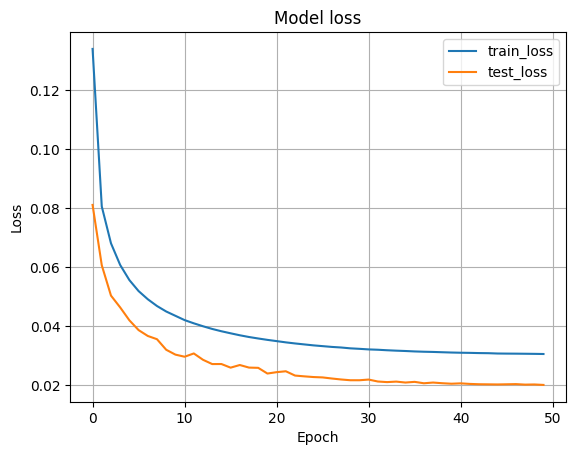

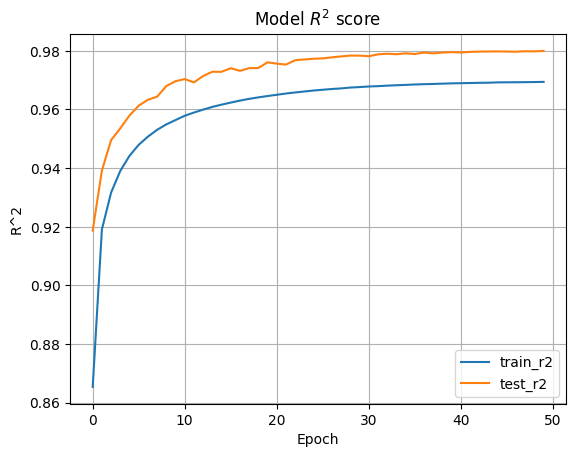

In [45]:
model = net_1m

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer,gamma=lr_decay_factor)

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
epochs = 50

losses = []
r2s = []
test_losses = []
test_r2s = []
cur_lrs =[]
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_r2 = 0.0
    for i, (inputs, targets) in enumerate(train_loader, 0):
        # Move inputs and targets to the device
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss (use the output from the last time step)
        loss = criterion(outputs, targets)
        r2 = R2Loss()(outputs, targets)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        running_r2 += r2.item()
        
    losses.append(running_loss / len(train_loader))
    r2s.append(running_r2 / len(train_loader))
    
    # Testing the model
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_r2 = 0.0
    with torch.no_grad():  # No need to compute gradients during testing
        for inputs, targets in test_loader:
            # Move inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the test loss
            loss = criterion(outputs, targets)
            r2 = R2Loss()(outputs, targets)
            
            # Accumulate the test loss
            test_loss += loss.item()
            test_r2 += r2.item()
            
    # Average test loss
    avg_test_loss = test_loss / len(test_loader)
    avg_test_r2 = test_r2 / len(test_loader)
    test_losses.append(avg_test_loss)
    test_r2s.append(avg_test_r2)
    print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {running_loss / len(train_loader):.3f}, Train R2: {running_r2/len(train_loader):.3f}, Test Loss: {avg_test_loss:.3f}, Test R2: {avg_test_r2:.3f}')
    
    current_lr = optimizer.param_groups[0]['lr']
    cur_lrs.append(current_lr)   
    scheduler.step()
    
    
print()
print('!!!Training complete!!!')
print()

# plotting model loss    
plt.plot(losses,label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend()
plt.grid()
plt.show()
# plotting model r2 score
plt.plot(r2s, label='train_r2')
plt.plot(test_r2s, label='test_r2')
plt.xlabel('Epoch')
plt.ylabel('R^2')
plt.title('Model $R^{2}$ score')
plt.legend()
plt.grid()
plt.show()

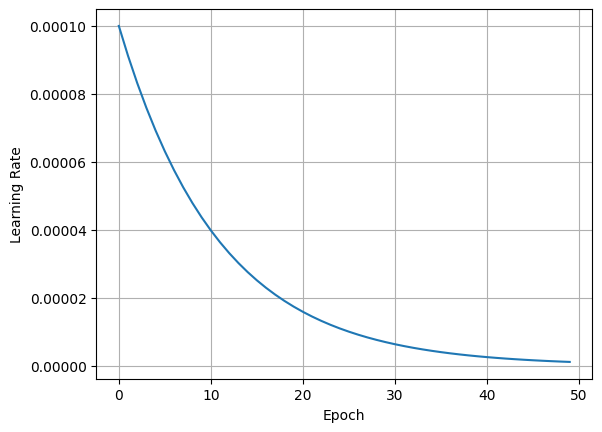

In [46]:
plt.plot( cur_lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid()
plt.show()

In [47]:
net_1m = model
path = 'cnn_1m_m_s'
torch.save(net_1m,path)

In [48]:
y_pred = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Predict outputs
        outputs = model(inputs)
        
        y_pred.append(outputs.cpu().numpy()) 

pred = np.concatenate(y_pred, axis=0)

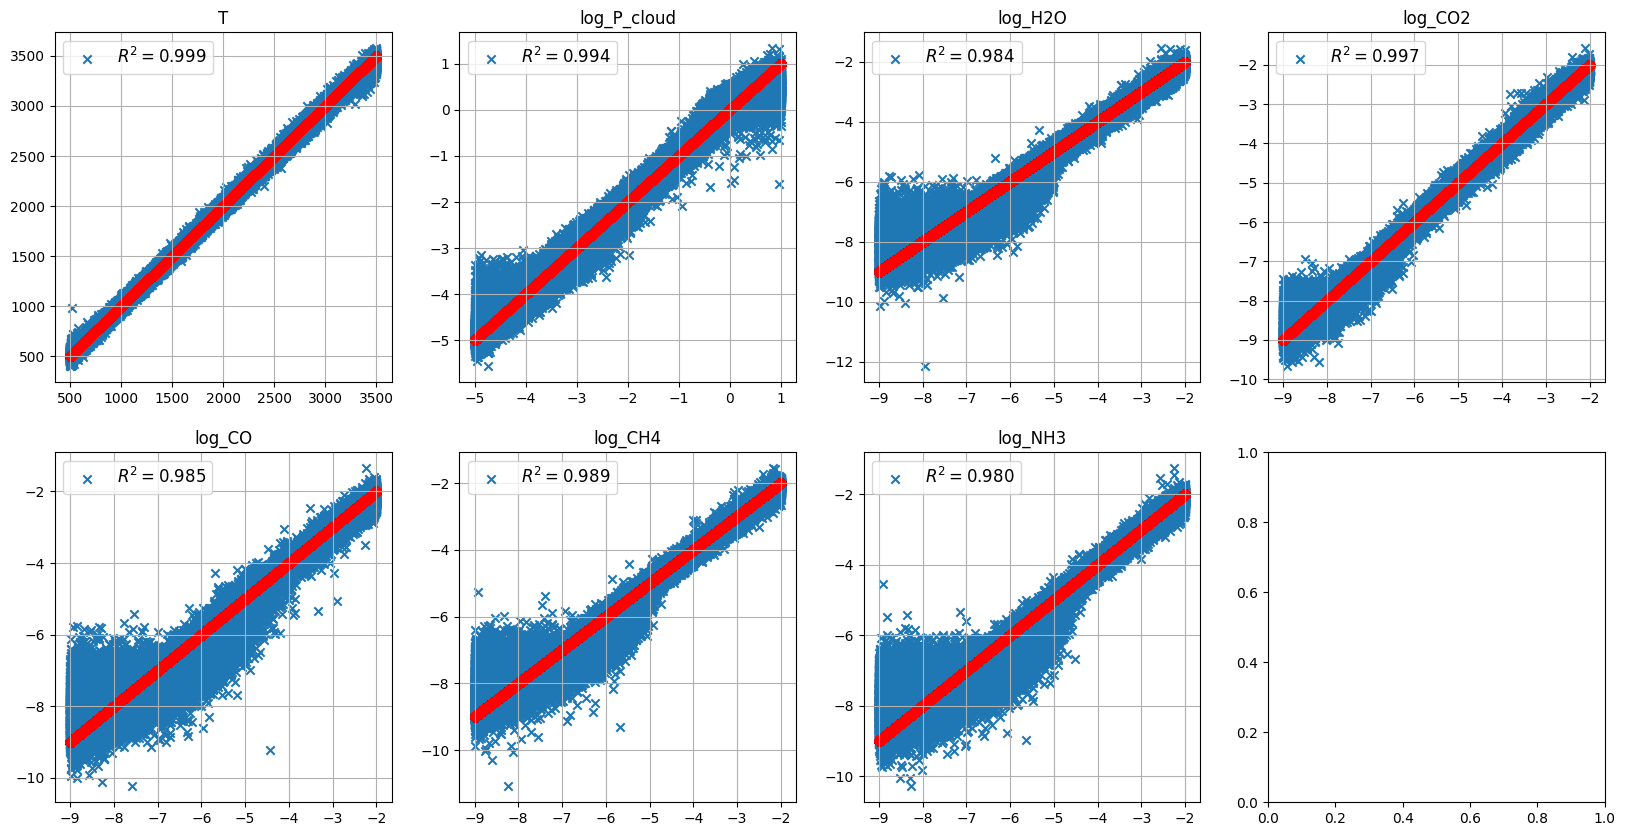

In [49]:
from scipy.stats import pearsonr

keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = pred
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[0,i].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test_rescaled[:,i])
        axs[1,i-4].scatter(y_test_rescaled[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_test_rescaled[:,i],y_test_rescaled[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

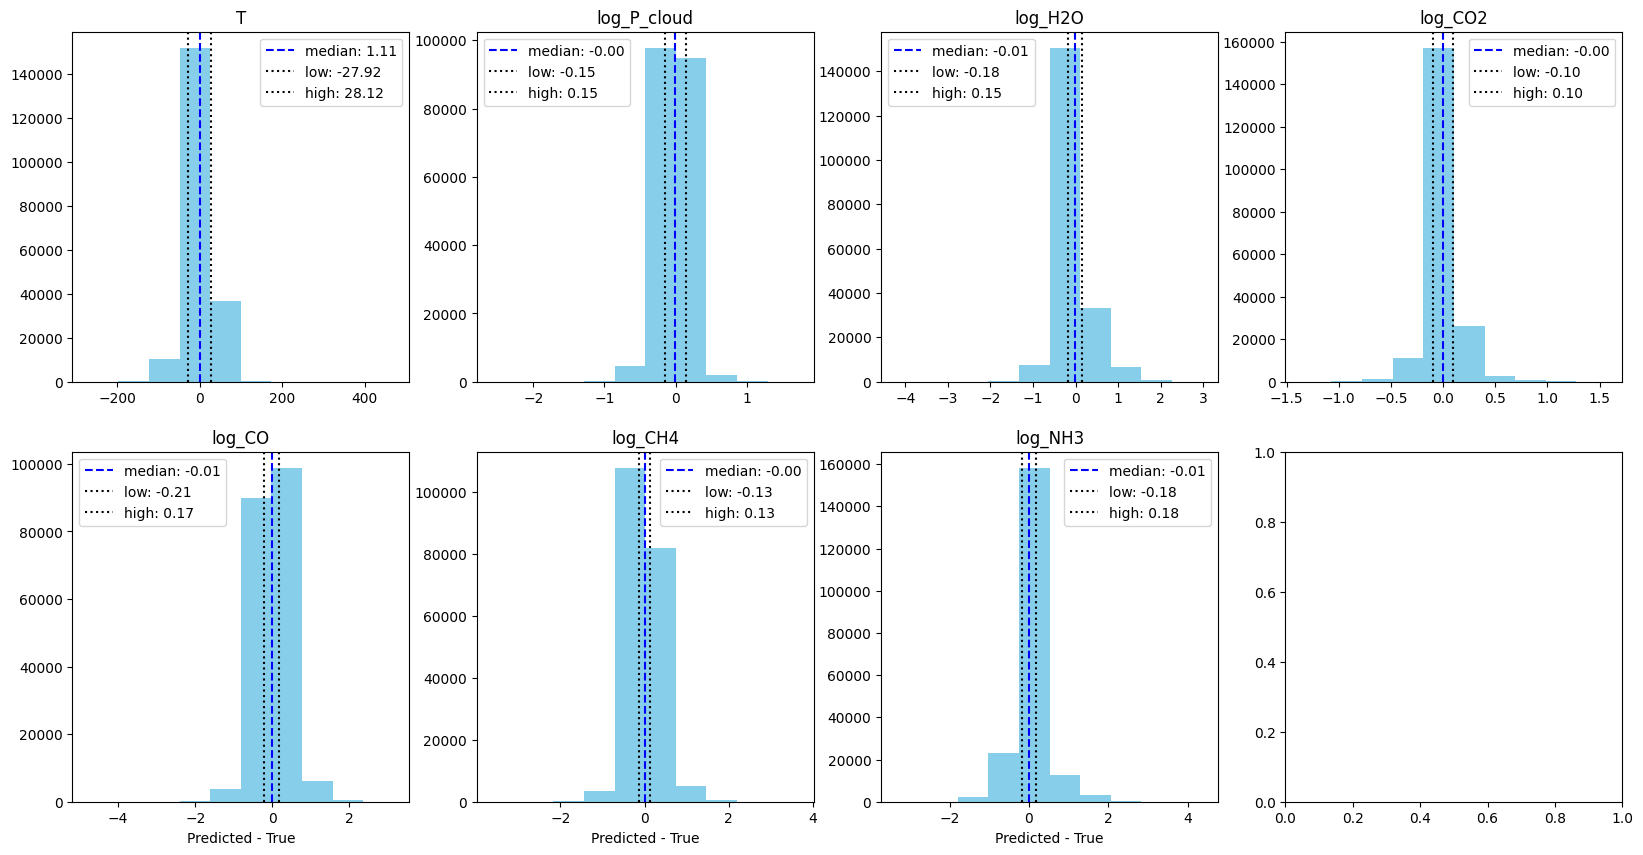

In [50]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

y_test_rescaled = scaler.inverse_transform(y_test)
predictions = pred
predictions = scaler.inverse_transform(predictions)

for i in range(7):
    if i < 4:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[0,i].hist(pred_err,bins=10,color='skyblue')
        axs[0,i].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[0,i].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[0,i].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err = predictions[:,i]-y_test_rescaled[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[1,i-4].hist(pred_err,bins=10,color='skyblue')
        axs[1,i-4].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[1,i-4].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[1,i-4].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')

In [51]:
y_test_rescaled_1M = scaler.inverse_transform(y_test)
predictions_1M = pred
predictions_1M = scaler.inverse_transform(predictions_1M)

In [52]:
pred_data = torch.from_numpy(test_planets).float()
with torch.no_grad():
    pred_data = pred_data.to(device)
    pred = net_1m(pred_data)    
pred = np.array(pred.cpu())    
pred = scaler.inverse_transform(pred)
pred

array([[ 2.0104381e+03,  1.3043338e-01, -7.3108130e+00, -7.9976072e+00,
        -5.0177779e+00, -3.5899096e+00, -4.1414981e+00],
       [ 1.0896489e+03,  4.5328885e-01, -2.7442951e+00, -2.7593949e+00,
        -9.1422434e+00, -5.8413801e+00, -5.1764240e+00],
       [ 2.6461821e+03, -3.6005201e+00, -5.4647927e+00, -5.2358122e+00,
        -6.3292217e+00, -2.8701510e+00, -5.4882798e+00]], dtype=float32)

In [53]:
planetA_pred_1M = pred[0]
print("Predicted values:",planetA_pred_1M)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.0104381e+03  1.3043338e-01 -7.3108130e+00 -7.9976072e+00
 -5.0177779e+00 -3.5899096e+00 -4.1414981e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


In [54]:
planetB_pred_1M = pred[1]
print("Predicted values:",planetB_pred_1M)
print("Actual values:",planetB_params[3:])

Predicted values: [ 1.0896489e+03  4.5328885e-01 -2.7442951e+00 -2.7593949e+00
 -9.1422434e+00 -5.8413801e+00 -5.1764240e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


In [55]:
planetC_pred_1M = pred[2]
print("Predicted values:",planetC_pred_1M)
print("Actual values:",planetC_params[3:])

Predicted values: [2646.1821      -3.6005201   -5.4647927   -5.235812    -6.3292217
   -2.870151    -5.48828  ]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


## Comparison

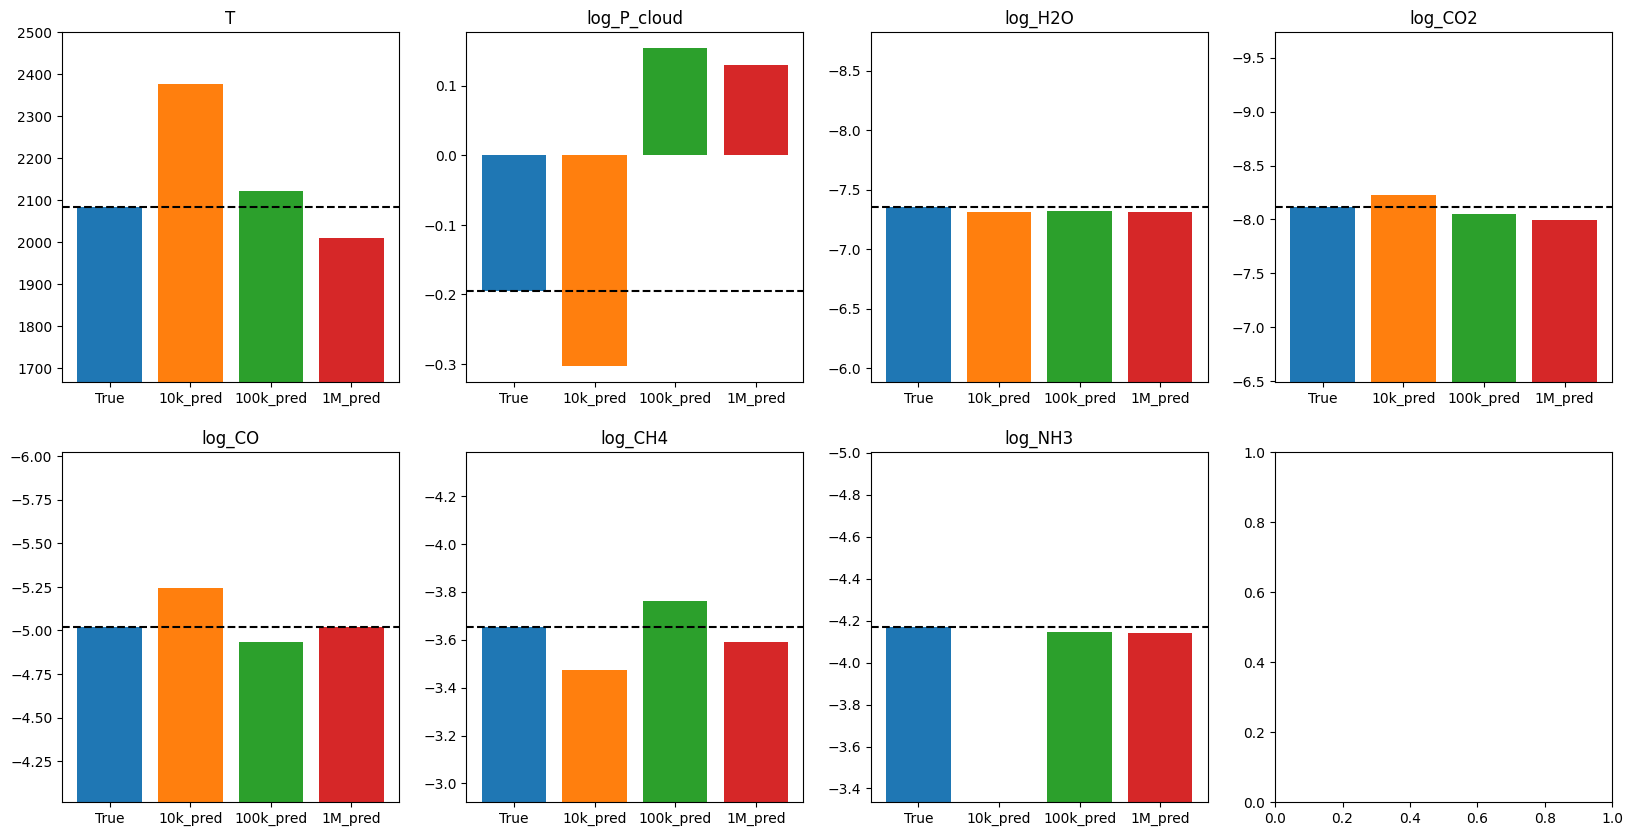

In [56]:
labels1 = ['True']
labels2 = ['10k_pred']
labels3 = ['100k_pred']
labels4 = ['1M_pred']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(7):
    if i < 2:
        axs[0,i].bar(labels1, planetA_params[3+i])
        axs[0,i].bar(labels2, planetA_pred_10k[i])
        axs[0,i].bar(labels3, planetA_pred_100k[i])
        axs[0,i].bar(labels4, planetA_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetA_params[3+i],color='black', linestyle='--')
        axs[0,0].set_ylim(0.80*planetA_params[3],1.20*planetA_params[3])
    elif i<4 and i>1:
        axs[0,i].bar(labels1, planetA_params[3+i])
        axs[0,i].bar(labels2, planetA_pred_10k[i])
        axs[0,i].bar(labels3, planetA_pred_100k[i])
        axs[0,i].bar(labels4, planetA_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetA_params[3+i],color='black', linestyle='--')
        axs[0,i].invert_yaxis()
        axs[0,i].set_ylim(0.80*planetA_params[3+i],1.20*planetA_params[3+i])
    else:
        axs[1,i-4].bar(labels1, planetA_params[3+i])
        axs[1,i-4].bar(labels2, planetA_pred_10k[i])
        axs[1,i-4].bar(labels3, planetA_pred_100k[i])
        axs[1,i-4].bar(labels4, planetA_pred_1M[i])
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].axhline(y=planetA_params[3+i],color='black', linestyle='--')
        axs[1,i-4].invert_yaxis()
        axs[1,i-4].set_ylim(0.80*planetA_params[3+i],1.20*planetA_params[3+i])
        
plt.savefig('comparison_plot1.png')

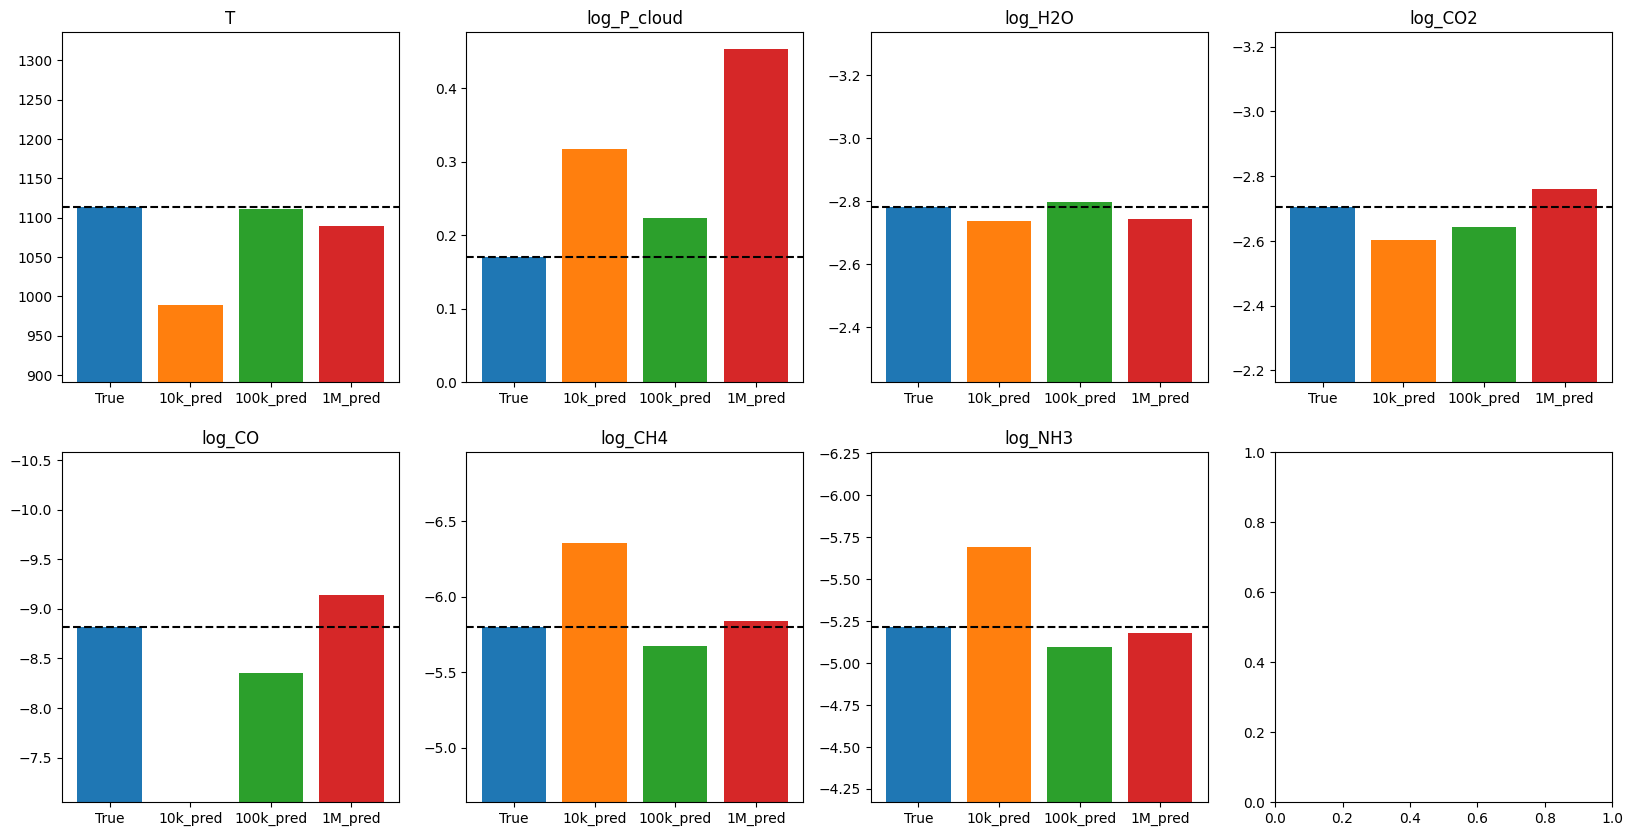

In [57]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(7):
    if i < 2:
        axs[0,i].bar(labels1, planetB_params[3+i])
        axs[0,i].bar(labels2, planetB_pred_10k[i])
        axs[0,i].bar(labels3, planetB_pred_100k[i])
        axs[0,i].bar(labels4, planetB_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetB_params[3+i],color='black', linestyle='--')
        axs[0,0].set_ylim(0.80*planetB_params[3],1.20*planetB_params[3])
    elif i<4 and i>1:
        axs[0,i].bar(labels1, planetB_params[3+i])
        axs[0,i].bar(labels2, planetB_pred_10k[i])
        axs[0,i].bar(labels3, planetB_pred_100k[i])
        axs[0,i].bar(labels4, planetB_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetB_params[3+i],color='black', linestyle='--')
        axs[0,i].invert_yaxis()
        axs[0,i].set_ylim(0.80*planetB_params[3+i],1.20*planetB_params[3+i])
    else:
        axs[1,i-4].bar(labels1, planetB_params[3+i])
        axs[1,i-4].bar(labels2, planetB_pred_10k[i])
        axs[1,i-4].bar(labels3, planetB_pred_100k[i])
        axs[1,i-4].bar(labels4, planetB_pred_1M[i])
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].axhline(y=planetB_params[3+i],color='black', linestyle='--')
        axs[1,i-4].invert_yaxis()
        axs[1,i-4].set_ylim(0.80*planetB_params[3+i],1.20*planetB_params[3+i])
        
plt.savefig('comparison_plot2.png')

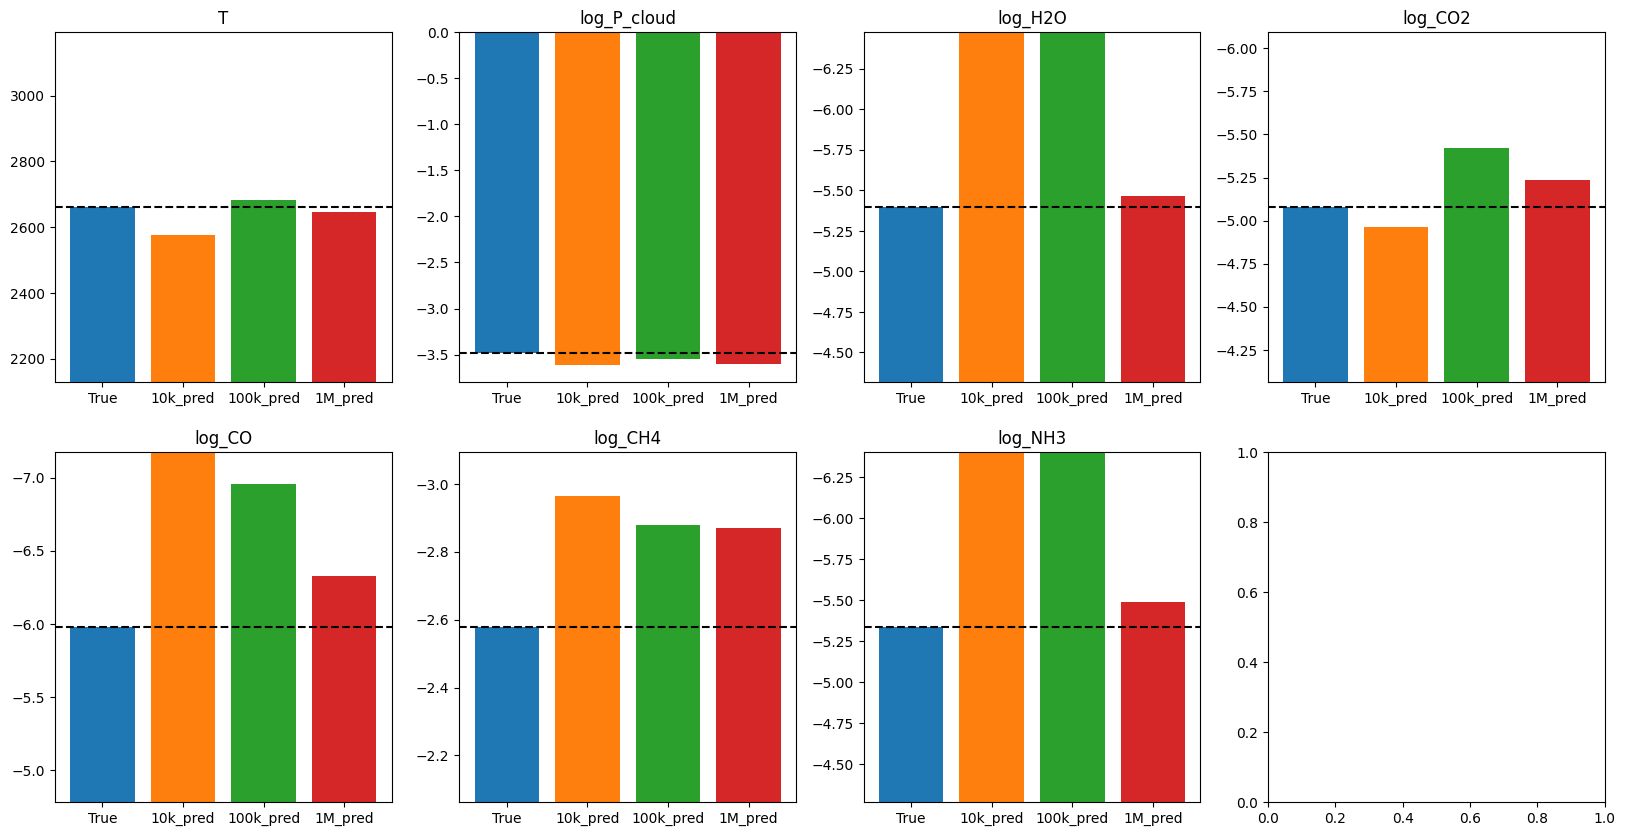

In [58]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(7):
    if i < 2:
        axs[0,i].bar(labels1, planetC_params[3+i])
        axs[0,i].bar(labels2, planetC_pred_10k[i])
        axs[0,i].bar(labels3, planetC_pred_100k[i])
        axs[0,i].bar(labels4, planetC_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetC_params[3+i],color='black', linestyle='--')
        axs[0,0].set_ylim(0.80*planetC_params[3],1.20*planetC_params[3])
    elif i<4 and i>1:
        axs[0,i].bar(labels1, planetC_params[3+i])
        axs[0,i].bar(labels2, planetC_pred_10k[i])
        axs[0,i].bar(labels3, planetC_pred_100k[i])
        axs[0,i].bar(labels4, planetC_pred_1M[i])
        axs[0,i].set_title(keys[i])
        axs[0,i].axhline(y=planetC_params[3+i],color='black', linestyle='--')
        axs[0,i].invert_yaxis()
        axs[0,i].set_ylim(0.80*planetC_params[3+i],1.20*planetC_params[3+i])
    else:
        axs[1,i-4].bar(labels1, planetC_params[3+i])
        axs[1,i-4].bar(labels2, planetC_pred_10k[i])
        axs[1,i-4].bar(labels3, planetC_pred_100k[i])
        axs[1,i-4].bar(labels4, planetC_pred_1M[i])
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].axhline(y=planetC_params[3+i],color='black', linestyle='--')
        axs[1,i-4].invert_yaxis()
        axs[1,i-4].set_ylim(0.80*planetC_params[3+i],1.20*planetC_params[3+i])
        
plt.savefig('comparison_plot3.png')

## Error histograms

In [59]:
y_test_rescaled_10k.shape, predictions_10k.shape

((2000, 7), (2000, 7))

In [60]:
y_test_rescaled_100k.shape, predictions_100k.shape

((20000, 7), (20000, 7))

In [61]:
y_test_rescaled_1M.shape, predictions_1M.shape

((199195, 7), (199195, 7))

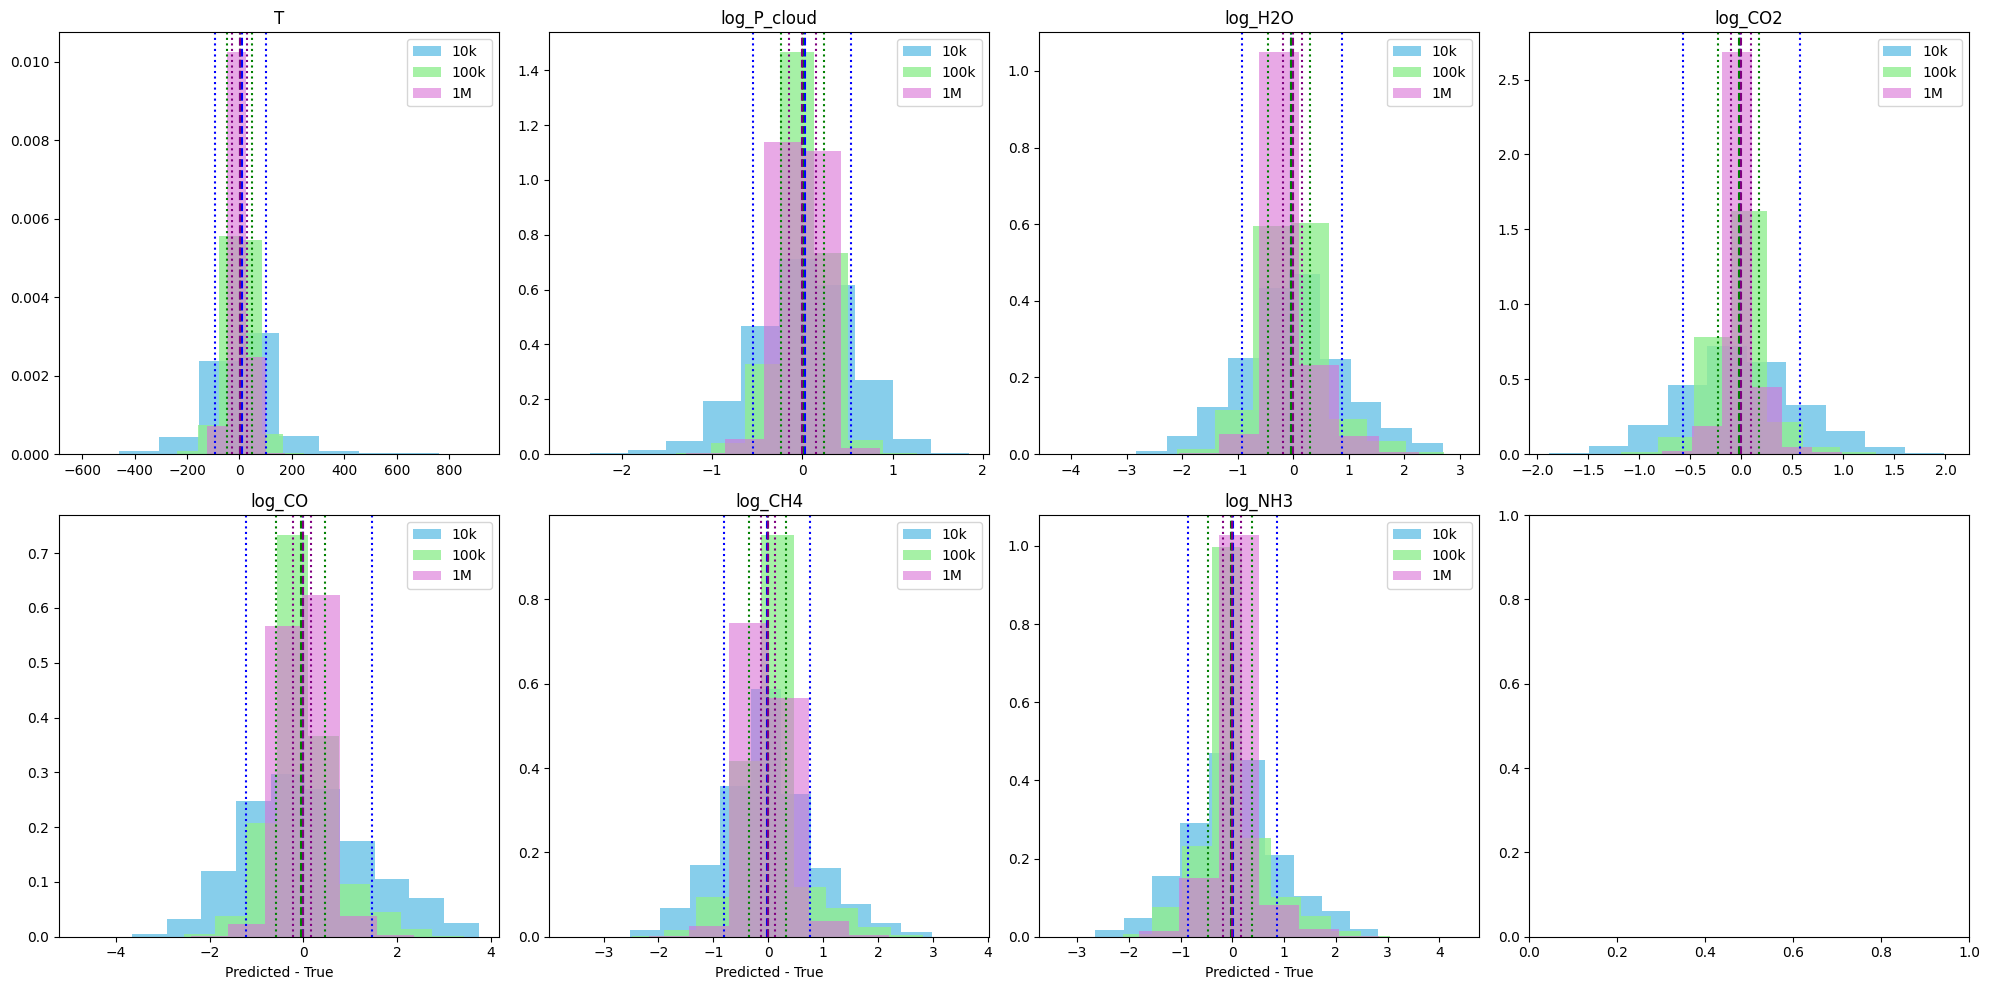

In [62]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(7):
    if i < 4:
        pred_err_10k = predictions_10k[:,i]-y_test_rescaled_10k[:,i]
        pred_err_100k = predictions_100k[:,i]-y_test_rescaled_100k[:,i]
        pred_err_1M = predictions_1M[:,i]-y_test_rescaled_1M[:,i]
        low_10k, med_10k, high_10k = np.percentile(pred_err_10k,(15.9,50,84.1))
        low_100k, med_100k, high_100k = np.percentile(pred_err_100k,(15.9,50,84.1))
        low_1M, med_1M, high_1M = np.percentile(pred_err_1M,(15.9,50,84.1))
        
        axs[0,i].hist(pred_err_10k,bins=10,color='skyblue',label='10k',density=True)
        axs[0,i].axvline(x=med_10k,color='blue',linestyle='--')
        axs[0,i].axvline(x=low_10k,color='blue',linestyle=':')
        axs[0,i].axvline(x=high_10k,color='blue',linestyle=':')

        axs[0,i].hist(pred_err_100k,bins=10,color='lightgreen',label='100k',density=True,alpha=0.8)
        axs[0,i].axvline(x=med_100k,color='green',linestyle='--')
        axs[0,i].axvline(x=low_100k,color='green',linestyle=':')
        axs[0,i].axvline(x=high_100k,color='green',linestyle=':')

        axs[0,i].hist(pred_err_1M,bins=10,color='orchid',label='1M',density=True,alpha=0.6)
        axs[0,i].axvline(x=med_1M,color='purple',linestyle='--')
        axs[0,i].axvline(x=low_1M,color='purple',linestyle=':')
        axs[0,i].axvline(x=high_1M,color='purple',linestyle=':')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err_10k = predictions_10k[:,i]-y_test_rescaled_10k[:,i]
        pred_err_100k = predictions_100k[:,i]-y_test_rescaled_100k[:,i]
        pred_err_1M = predictions_1M[:,i]-y_test_rescaled_1M[:,i]
        low_10k, med_10k, high_10k = np.percentile(pred_err_10k,(15.9,50,84.1))
        low_100k, med_100k, high_100k = np.percentile(pred_err_100k,(15.9,50,84.1))
        low_1M, med_1M, high_1M = np.percentile(pred_err_1M,(15.9,50,84.1))
        
        axs[1,i-4].hist(pred_err_10k,bins=10,color='skyblue',label='10k',density=True)
        axs[1,i-4].axvline(x=med_10k,color='blue',linestyle='--')
        axs[1,i-4].axvline(x=low_10k,color='blue',linestyle=':')
        axs[1,i-4].axvline(x=high_10k,color='blue',linestyle=':')

        axs[1,i-4].hist(pred_err_100k,bins=10,color='lightgreen',label='100k',density=True,alpha=0.8)
        axs[1,i-4].axvline(x=med_100k,color='green',linestyle='--')
        axs[1,i-4].axvline(x=low_100k,color='green',linestyle=':')
        axs[1,i-4].axvline(x=high_100k,color='green',linestyle=':')

        axs[1,i-4].hist(pred_err_1M,bins=10,color='orchid',label='1M',density=True,alpha=0.6)
        axs[1,i-4].axvline(x=med_1M,color='purple',linestyle='--')
        axs[1,i-4].axvline(x=low_1M,color='purple',linestyle=':')
        axs[1,i-4].axvline(x=high_1M,color='purple',linestyle=':')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')
plt.tight_layout()
plt.savefig('error_histograms1.png')

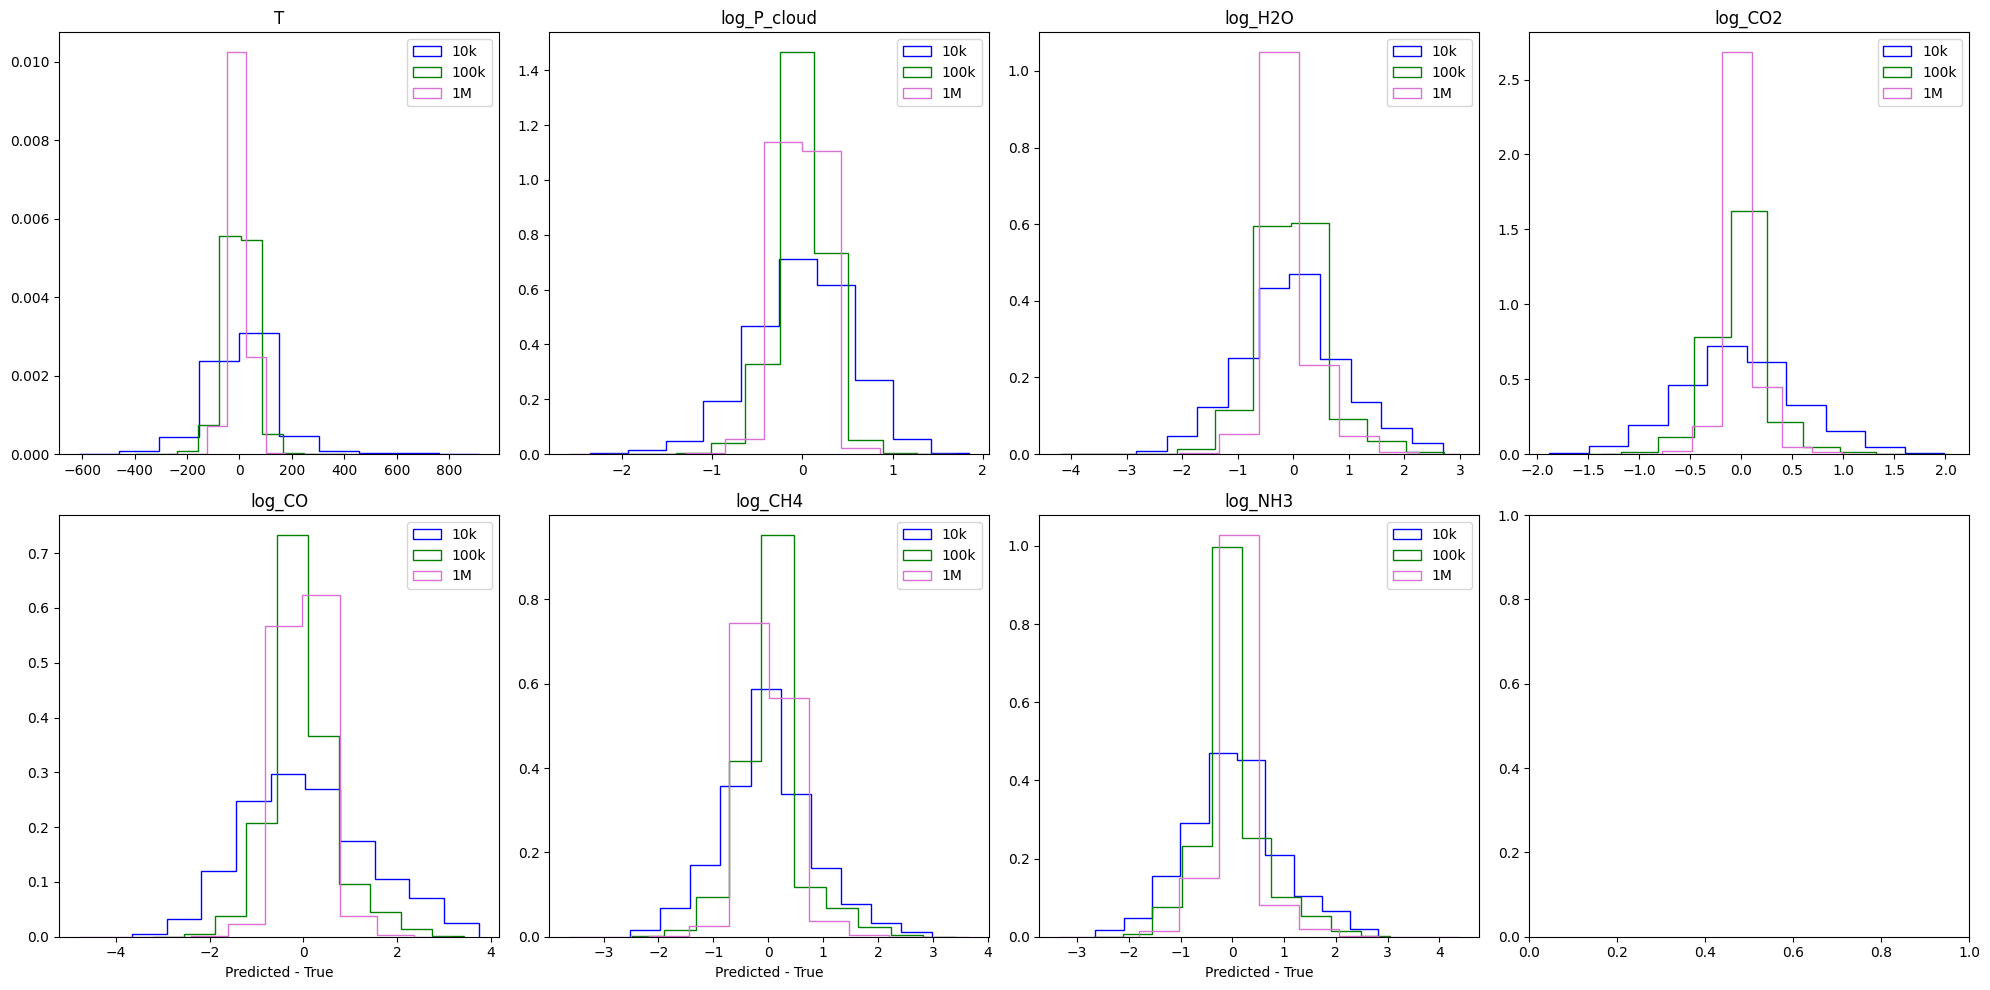

In [63]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(7):
    if i < 4:
        pred_err_10k = predictions_10k[:,i]-y_test_rescaled_10k[:,i]
        pred_err_100k = predictions_100k[:,i]-y_test_rescaled_100k[:,i]
        pred_err_1M = predictions_1M[:,i]-y_test_rescaled_1M[:,i]
        low_10k, med_10k, high_10k = np.percentile(pred_err_10k,(15.9,50,84.1))
        low_100k, med_100k, high_100k = np.percentile(pred_err_100k,(15.9,50,84.1))
        low_1M, med_1M, high_1M = np.percentile(pred_err_1M,(15.9,50,84.1))
        
        axs[0,i].hist(pred_err_10k,bins=10,color='blue',label='10k',density=True,histtype='step')
    
        axs[0,i].hist(pred_err_100k,bins=10,color='green',label='100k',density=True,histtype='step')
        

        axs[0,i].hist(pred_err_1M,bins=10,color='orchid',label='1M',density=True,histtype='step')

        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err_10k = predictions_10k[:,i]-y_test_rescaled_10k[:,i]
        pred_err_100k = predictions_100k[:,i]-y_test_rescaled_100k[:,i]
        pred_err_1M = predictions_1M[:,i]-y_test_rescaled_1M[:,i]
        low_10k, med_10k, high_10k = np.percentile(pred_err_10k,(15.9,50,84.1))
        low_100k, med_100k, high_100k = np.percentile(pred_err_100k,(15.9,50,84.1))
        low_1M, med_1M, high_1M = np.percentile(pred_err_1M,(15.9,50,84.1))
        
        axs[1,i-4].hist(pred_err_10k,bins=10,color='blue',label='10k',density=True,histtype='step')


        axs[1,i-4].hist(pred_err_100k,bins=10,color='green',label='100k',density=True,histtype='step')


        axs[1,i-4].hist(pred_err_1M,bins=10,color='orchid',label='1M',density=True,histtype='step')

        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')
plt.tight_layout()
plt.savefig('error_histograms2.png')